In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import scipy.sparse
import vectorizers
import vectorizers.transformers
import igraph as ig
from scipy.sparse import vstack
from collections import Counter
import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors


# Datasets

Dataset; #graphs; #nodes; #nodes in giant comps

* MUTAG; 188; 3,371; 3,371
* BZR; 405; 14,479; 14,479
* NCI1; 4110; 122,747; 119,345
* NCI109; 4127; 122,494; 119,162
* IMDB-BINARY; 1000; 19,773; 19,773
* REDDIT-BINARY; 2000; 859,254; 851,133


In [2]:
dataset = 'BZR'
datadir = '../Data/'+dataset+'/'+dataset

## read data from folder
fn_edges = datadir+'.edges'
fn_graph_id = datadir+'.graph_id'
fn_graph_label = datadir+'.graph_labels'


In [3]:
## read edges, build overall graph
with open(fn_edges) as f:
    E = [tuple(map(int,x.strip().split(','))) for x in f.readlines()]
G = ig.Graph.TupleList(E, directed=True).as_undirected()

## read subgraph node memberships (subgraphs names are 1-based)
with open(fn_graph_id) as f:
    sg_mem = [int(x.strip())-1 for x in f.readlines()]

## build dictionary (node names are 1-based)
graph_dict = {(x+1):y for x,y in enumerate(sg_mem)}
for v in G.vs:
    v['graph'] = graph_dict[v['name']]

## read graph labels
with open(fn_graph_label) as f:
    graph_labels = [int(x.strip()) for x in f.readlines()]
print('number of graphs:',len(graph_labels))


number of graphs: 405


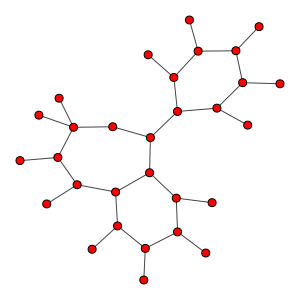

In [4]:
## subgraphs - example
sg_id = 0
sg = G.subgraph(np.where(np.array(G.vs['graph']) == sg_id)[0].tolist())
ig.plot(sg, bbox=(300,300), vertex_size=8)

### Method 1 - Expander-based Node Features

For every "small" graphs, compute some features derived from expansion properties of vertices.

See details in our blog post.

We can ignore the **node labels** if we want to compare with methods that rely only on the graph structure.


In [5]:
## by default, we ignore vertex labels.
def get_sg_features(sg, depth=7, add_features=False):
    F = []
    n = sg.vcount()
    m = sg.ecount()
    sg.vs['deg'] = sg.degree()
    Excess = np.array(sg.degree())-1
    Exp_q = (sum((Excess+1)*Excess)/(2*m))
    Var_q = sum((Excess+1)*Excess*Excess)/(2*m) - Exp_q**2
    if Var_q > 0:
        sg.vs['assort'] = Excess*(Excess+1)*(np.array([np.mean([Excess[j] for j in sg.neighbors(i)]) for i in range(n)]) - Exp_q)/(2*m*Var_q)
    else:
        sg.vs['assort'] = 1
    
    if add_features:
        features = [np.array(sg.degree()),
                    sg.transitivity_local_undirected(mode='zero'),
                    np.array(sg.betweenness())/n**2,
                    sg.pagerank(),
                    np.array(sg.coreness()),
                    sg.vs['assort']
                   ] 
        for j in range(len(features)):
            F.append(features[j])
    ## now consider increading depths
    for i in range(depth):
        current = sg.neighborhood_size(order=i+1)
        ## expanding proportion
        F.append([j/n for j in current])
        ## relative expanding properties
        if i>0:
            F.append([j / k for j, k in zip(current, previous)])
        previous = current
        ## aggregate of other features at this depth
        if add_features:
            sg_nei = sg.neighborhood(order=i+1)
            for j in range(len(features)):
                F.append([np.mean([features[j][k] for k in x]) for x in sg_nei])
    F = np.array(F).transpose()
    return F

### Input format

* **node_features**: array (length = number of graphs) of arrays of size "number of vertices x number of features"

Below, we prepare the data we have in this format.

In [6]:
%%time
## feature for every graph - this is the slowest part
node_features = []
rows = []
ctr = 1
for i in list(set(G.vs['graph'])):
    ## we keep the giant component for each small graph
    sg = G.subgraph(np.where(np.array(G.vs['graph']) == i)[0].tolist()).connected_components().giant()
    node_features.append(get_sg_features(sg, depth=7, add_features=True))
    rows.extend(np.repeat(i,sg.vcount()))
    ctr += 1
    if ctr % 250 == 0:
        print(ctr)
node_features = np.array(node_features, dtype=object)


250
CPU times: user 5.56 s, sys: 42 ms, total: 5.6 s
Wall time: 5.63 s


### first step - build (graphs x nodes) sparse incidence matrix


In [7]:
## consider all node's feature vectors
node_vectors = np.vstack(node_features)

In [8]:
%%time
## incidence - this is quite fast
n = len(rows)
cols = np.arange(n)
incidence_matrix = scipy.sparse.csr_matrix((np.repeat(1.0,n).astype(np.float32), (rows, cols)))
incidence_matrix

CPU times: user 3.01 ms, sys: 1.32 ms, total: 4.33 ms
Wall time: 4.26 ms


<405x14479 sparse matrix of type '<class 'numpy.float32'>'
	with 14479 stored elements in Compressed Sparse Row format>

### second step - embed graphs via Wasserstein's

In [9]:
%%time
## embed the graphs via distributions over node vectors - also fast
graphs_embed = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(incidence_matrix, vectors=node_vectors)
graphs_embed.shape

CPU times: user 179 ms, sys: 78.6 ms, total: 257 ms
Wall time: 52.9 ms


(405, 61)

In [10]:
%%time
## same as above, but with normalized vectors
node_vectors_norm = normalize(node_vectors, axis=1, norm='l1')
graphs_embed_norm = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(incidence_matrix, vectors=node_vectors_norm)
graphs_embed_norm.shape

CPU times: user 148 ms, sys: 98.6 ms, total: 246 ms
Wall time: 41.7 ms


(405, 61)

## Recursive part - looking at each node's neighbourhood

This is based on Valerie's experiment: https://github.com/vpoulin/graphs-Vectorization

We do a single iteration below.


In [11]:
## some work req'd as we kept only the giant components from overall graph G
## we could speed this up when building G in the first place if required (TBD)
G_pruned = G.copy()
drop = set()
for i in list(set(G_pruned.vs['graph'])):
    sg = G_pruned.subgraph(np.where(np.array(G_pruned.vs['graph']) == i)[0].tolist()).connected_components().giant()
    ssg = G_pruned.subgraph(np.where(np.array(G_pruned.vs['graph']) == i)[0].tolist())
    if sg.vcount() != ssg.vcount():
        drop = drop.union(set(ssg.vs['name']) - set(sg.vs['name']))
G_pruned.delete_vertices([G_pruned.vs.find(name=x).index for x in drop])
G_pruned.vcount()


14479

In [12]:
%%time
## incidence matrix
node_incidence_matrix = G_pruned.get_adjacency_sparse()
node_incidence_matrix.setdiag(1) ## add self to neighbourhoods


CPU times: user 128 ms, sys: 4.41 ms, total: 132 ms
Wall time: 134 ms


In [13]:
%%time
## apply recursion
n_components = node_vectors.shape[1]
svd = TruncatedSVD(n_components=n_components)

node_vectors_expand = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(node_incidence_matrix, vectors=node_vectors_norm)

node_vectors_expand = normalize(node_vectors_expand, axis=1, norm='l1')

graphs_embed_expand = vectorizers.ApproximateWassersteinVectorizer(
    random_state=42,
    normalization_power=0.66,
).fit_transform(incidence_matrix, vectors=np.hstack([node_vectors_norm,node_vectors_expand]))
graphs_embed_expand_svd = svd.fit_transform(graphs_embed_expand)


CPU times: user 1.11 s, sys: 1.13 s, total: 2.24 s
Wall time: 358 ms


In [14]:
##save results
import pickle
fn = 'Results/expander_'+dataset+'.pkl'
with open(fn,'wb') as fp:
    pickle.dump( (graphs_embed,
                  graphs_embed_norm,
                  graphs_embed_expand,
                  graphs_embed_expand_svd), 
                  fp
    )


In [15]:
#print(len(set(G.vs['graph'])), G.vcount(), G_pruned.vcount())

405 14479 14479


### Assortativity (local)